In [ ]:
#pip install GDAL-3.4.3-cp39-cp39-win_amd64.whl

In [1]:
import os
import osgeo
from osgeo import gdal, osr, ogr, gdalconst
import numpy as np
from skimage.transform import resize
import progressbar as pbar
from zipfile import ZipFile
from glob import glob
import boto3
import time
import rasterio
import fiona
import matplotlib.pyplot as plt
from rasterio import warp, features
gdal.UseExceptions()

GDAL_TYPE_LOOKUP = {'float32': gdal.GDT_Float32,
                    'float64': gdal.GDT_Float64,
                    'uint16': gdal.GDT_UInt16,
                    'uint8': gdal.GDT_Byte}

RESAMPLE_ALGO_DICT = {'no': None,
                     'max': gdalconst.GRA_Max,
                      'mean': gdalconst.GRA_Average,
                      'bilinear': gdalconst.GRA_Bilinear,
                      'cubic': gdalconst.GRA_Cubic,
                      'nearest': gdalconst.GRA_NearestNeighbour}

def sort_band_arrays(band_arrays, channels_last=True):
    bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
    out_arr = []
    for b in bands:
        out_arr.append(band_arrays[b])
    out_arr = np.array(out_arr)
    if channels_last:
        out_arr = np.moveaxis(out_arr, source=0, destination=-1)
    return out_arr

def read_band(path_band, num_retries=10, max_sleep_sec=5):
    for i in range(num_retries):
        try:
            ds = gdal.Open(path_band)
            band = ds.GetRasterBand(1)
            print('reading full band array...')
            band_array = band.ReadAsArray()
            return band_array
        except: 
            print('Attempt {}/{} failed reading path: {}'.format(i, num_retries, path_band))
            time.sleep(np.random.randint(max_sleep_sec))
            continue
        # raise an error if max retries is reached
    raise RuntimeError("read_band() failed {} times reading path: {}".format(num_retries, path_band))   

def read_sentinel2_bands(data_path, from_aws=False, bucket='sentinel-s2-l2a', channels_last=False):
    bands10m = ['B02', 'B03', 'B04', 'B08']
    bands20m = ['B05', 'B06', 'B07', 'B8A', 'B11', 'B12', 'SCL']
    bands60m = ['B01', 'B09']  # 'B10' is missing in 2A, exists only in 1C

    bands_dir = {10: {'band_names': bands10m, 'subdir': 'R10m', 'scale': 1},
                 20: {'band_names': bands20m, 'subdir': 'R20m', 'scale': 2},
                 60: {'band_names': bands60m, 'subdir': 'R60m', 'scale': 6}}

    if '.zip' in data_path:
        archive = ZipFile(data_path, 'r')  # data_path is path to zip file

    band_arrays = {}
    tile_info = None
    for res in bands_dir.keys():
        bands_dir[res]['band_data_list'] = []
        for i in range(len(bands_dir[res]['band_names'])):
            band_name = bands_dir[res]['band_names'][i]

            if from_aws:
                print('Opening bands with gdal vsis3...')
                path_band = os.path.join('/vsis3', bucket, data_path, bands_dir[res]['subdir'], band_name + '.jp2')
            else:
                # get datapath within zip file
                # get path to IMG_DATA
                path_img_data = \
                [name for name in archive.namelist() if name.endswith('{}_{}m.jp2'.format(band_name, res))][0]
                path_band = os.path.join(data_path, path_img_data)
                path_band = '/vsizip/' + path_band

            print('path_band: ', path_band)
            if not tile_info:
                ds = gdal.Open(path_band)
                tile_info = get_tile_info(ds)

            # read all band data to memory once
            band_arrays[band_name] = read_band(path_band=path_band)

    print("Opening CLD band...")
    if from_aws:
        path_band = os.path.join('/vsis3', bucket, data_path, 'qi', 'CLD_20m.jp2')
    else:
        path_img_data = \
        [name for name in archive.namelist() if name.endswith('CLD_20m.jp2') or name.endswith('MSK_CLDPRB_20m.jp2')][0]
        path_band = os.path.join(data_path, path_img_data)
        path_band = '/vsizip/' + path_band
    print('cloud path_band:', path_band)

    band_arrays['CLD'] = read_band(path_band=path_band)

    target_shape = band_arrays['B02'].shape
    print('resizing 20m and 60m bands to 10m resolution...')
    for band_name in band_arrays:
        band_array = band_arrays[band_name]
        if band_array.shape != target_shape:
            if band_name in ['SCL']:
                order = 0  # nearest
            else:
                order = 3  # bicubic

            band_arrays[band_name] = resize(band_array, target_shape, mode='reflect',
                                            order=order, preserve_range=True).astype(np.uint16)
    print('sorting bands...')
    image_array = sort_band_arrays(band_arrays=band_arrays, channels_last=channels_last)
    return image_array, tile_info, band_arrays['SCL'], band_arrays['CLD']

def load_tif_as_array(path, set_nodata_to_nan=True):
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)

    array = band.ReadAsArray().astype(float)
    tile_info = get_tile_info(ds)
    # set the nodata values to nan
    nodata_value = band.GetNoDataValue()
    tile_info['nodata_value'] = nodata_value
    if set_nodata_to_nan:
        array[array == nodata_value] = np.nan
    return array, tile_info

def get_tile_info(refDataset):
    tile_info = {}
    tile_info['projection'] = refDataset.GetProjection()
    tile_info['geotransform'] = refDataset.GetGeoTransform()
    tile_info['width'] = refDataset.RasterXSize
    tile_info['height'] = refDataset.RasterYSize
    return tile_info

'''
get split mask based on train val shp
output array with target_file shape (0 -> train, 1-> val)
'''
def splitTrainVal(trainshp, valshp, target_file):
    target = rasterio.open(target_file)
    trainmask = projectToTarget(trainshp, target)
    valmask = projectToTarget(valshp, target)

    mask = np.ones(target.shape).astype(int)*2
    mask[trainmask==1] = 0
    mask[valmask==1] = 1
    return mask

'''
project src shapefile to target crs with target.shape
srcshp: file path
target: result of rasterio.open(target_file_path)

return an image array
'''
def projectToTarget(srcshp, target, dtype='uint8'):
    reprojected = np.zeros(target.shape).astype(int)
    
    polygon = fiona.open(srcshp)
    srccrs = polygon.crs
    
    while True:
        try:
            poly = polygon.next()

            poly_trans = warp.transform_geom(srccrs, target.crs, poly['geometry'])
            rasterized_polygon = features.rasterize(
                [(poly_trans, 1)],
                out_shape=target.shape,
                transform=target.transform,
                fill=0,
                dtype=dtype
            )
            reprojected += rasterized_polygon
            print("reprojecting")
        except StopIteration:
            break
    
    return reprojected

In [2]:
s2_array, tile_info, scl, cld = read_sentinel2_bands("C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_20200708T102559_N0214_R108_T32TMT_20200708T135942.zip")

path_band:  /vsizip/C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_20200708T102559_N0214_R108_T32TMT_20200708T135942.zip\GRANULE/L2A_T32TMT_A017437_20200708T103435/IMG_DATA/R10m/T32TMT_20200708T102559_B02_10m.jp2
reading full band array...
path_band:  /vsizip/C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_20200708T102559_N0214_R108_T32TMT_20200708T135942.zip\GRANULE/L2A_T32TMT_A017437_20200708T103435/IMG_DATA/R10m/T32TMT_20200708T102559_B03_10m.jp2
reading full band array...
path_band:  /vsizip/C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_20200708T102559_N0214_R108_T32TMT_20200708T135942.zip\GRANULE/L2A_T32TMT_A017437_20200708T103435/IMG_DATA/R10m/T32TMT_20200708T102559_B04_10m.jp2
reading full band array...
path_band:  /vsizip/C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_20200708T102559_N0214_R108_T32TMT_20200708T135942.zip\GRANULE/L2A_T32TMT_A017437_20200708T103435/IMG_DATA/R10m/T32TMT_20200708T102559_B08_10m.jp2
reading full band array...
path_band:  /vsizip/C:/Users/taylan/pytorchgpu/S2/S2B_MSIL2A_202

In [3]:
tif_raster = rasterio.open("fine_als/VHM_swissSurface3D_reprojected_10m_mean_32TNS.tif")
srcshp = "shp/2020.shp"

In [4]:
mask = projectToTarget(srcshp,tif_raster)
mask

C:\Users\taylan\AppData\Local\Temp\ipykernel_8556\640100732.py:170: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  poly = polygon.next()


reprojecting


C:\Users\taylan\AppData\Local\Temp\ipykernel_8556\640100732.py:170: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  poly = polygon.next()


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [5]:
from patchify import patchify

In [5]:
n = 6
s2 = np.arange(0,2 * n * n).reshape(2,n,n)
mask = np.random.randint(0,2,(s2.shape[1],s2.shape[2]))
s2.shape, mask.shape

((2, 6, 6), (6, 6))

In [6]:
def patchify2(image, patch_size, step=None):
    if step is None:
        step = patch_size
    height, width = image.shape[:2]
    patch_rows = (height - patch_size[0]) // step[0] + 1
    patch_cols = (width - patch_size[1]) // step[1] + 1
    patch_list = []
    patches = np.empty((patch_rows, patch_cols, patch_size[0], patch_size[1]), dtype=image.dtype)
    for i in range(patch_rows):
        for j in range(patch_cols):
            patch = image[i * step[0] : i * step[0] + patch_size[0], j * step[1] : j * step[1] + patch_size[1]]
            patches[i,j] = patch
    return patches

In [6]:
patch_size = 500
patched_images = patchify(s2_array[0], (patch_size,patch_size), step = patch_size)
patched_reshaped_images = patched_images.reshape(-1,patch_size,patch_size)
patched_mask = patchify(mask, (patch_size,patch_size), step = patch_size)
patched_reshaped_mask = patched_mask.reshape(-1,patch_size,patch_size)
patched_reshaped_validated_images = patched_reshaped_images[np.array(patched_reshaped_mask[:,patch_size//2,patch_size//2], dtype = bool)]
#result = patched_reshaped_images[np.where(mask[patch_size//2 : -patch_size//2 + 1, patch_size//2 -1 : -patch_size//2].flatten() == 1)[0],:,:]

In [7]:
patched_images.shape

(21, 21, 500, 500)

In [8]:
def patch_reshape(image,patch_size = 64):
    patched_image = patchify(image, (patch_size,patch_size), step = patch_size)
    patched_reshaped_image = patched_image.reshape(-1,patch_size,patch_size)
    return patched_reshaped_image

In [9]:
def filter_valid(image, mask, patch_size = 64):
    assert image.shape == mask.shape
    patched_reshaped_image = patch_reshape(image, patch_size)
    patched_reshaped_mask = patch_reshape(mask, patch_size)
    result = patched_reshaped_image[np.array(patched_reshaped_mask[:,patch_size//2,patch_size//2], dtype = bool)]
    return result

In [81]:
a = np.array([filter_valid(s2_array[i],mask) for i in range(s2_array.shape[0])])

In [61]:
reshaped_array = np.transpose(a, (1, 0, 2, 3))

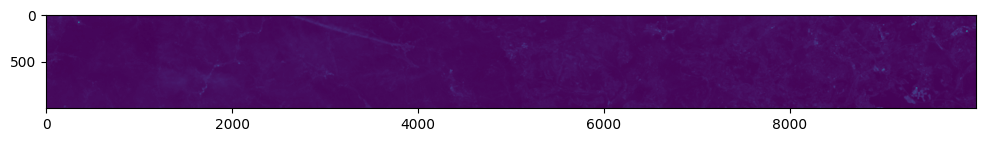

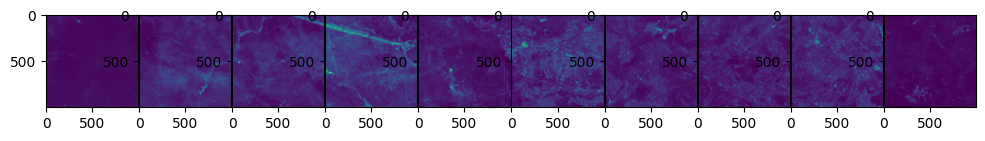

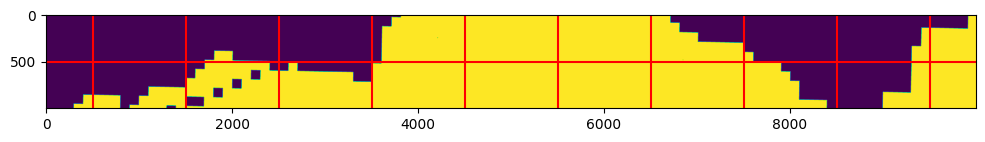

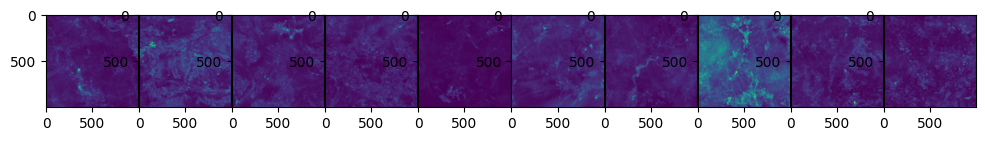

In [85]:
patch_size = 1000
patched_images = patchify(s2_array[0], (patch_size,patch_size), step = patch_size)
patched_reshaped_images = patched_images.reshape(-1,patch_size,patch_size)
patched_mask = patchify(mask, (patch_size,patch_size), step = patch_size)
patched_reshaped_mask = patched_mask.reshape(-1,patch_size,patch_size)
patched_reshaped_validated_images = patched_reshaped_images[np.array(patched_reshaped_mask[:,patch_size//2,patch_size//2], dtype = bool)]

plt.figure(figsize=(12,12))
plt.imshow(s2_array[0][0:patch_size * 1, 0: patch_size * x])
plt.show()

x = 10
_, axs = plt.subplots(1, x, figsize=(12, 12))
axs = axs.flatten()
i = 0
for img, ax in zip(patched_reshaped_images, axs):
    ax.imshow(img)
    i = i + 1   
plt.subplots_adjust(wspace=0.01)
plt.show()

plt.figure(figsize=(12,12))
mask_sub = mask[0:patch_size * 1, 0: patch_size * x]
width = mask_sub.shape[0]
# Calculate the x-coordinate of the middle pixel
middle_y = width // 2
# Draw a vertical red line at the middle
for i in np.linspace(patch_size//2,mask_sub.shape[1] - patch_size//2,x):
    plt.axvline(x=i, color = "red")

plt.axhline(y=middle_y, color='red')
plt.imshow(mask_sub)
plt.show()

_, axs = plt.subplots(1, x, figsize=(12, 12))
axs = axs.flatten()
i = 0
for img, ax in zip(patched_reshaped_validated_images, axs):
    ax.imshow(img)
    i = i + 1   
plt.subplots_adjust(wspace=0.01)
plt.show()

In [12]:
tif_array, info = load_tif_as_array("C:/Users/taylan/pytorchgpu/fine_als/VHM_swissSurface3D_reprojected_10m_mean_32TMS.tif")

In [13]:
tif_array.shape

(10980, 10980)

In [14]:
tif_valid = filter_valid(tif_array,mask)

In [15]:
tif_valid.shape

(14769, 64, 64)

In [ ]:
a = np.zeros((4,4))
a[a.shape[0]//2,a.shape[0]//2] = 1
plt.imshow(a)